## This notebook can be used to rank get a ranked path between A and B given a set of paths in Translator


In [1]:
# include path ../src in order to import modules
import sys
sys.path.append('../src')
import TCT as TCT
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Step1: List all the APIs in the translator system
APInames = TCT.list_Translator_APIs()
print(len(APInames))
#print(APInames.keys())

65


In [3]:
# Step 2: Get metaKG and all predicates from Translator APIs
#metaKG = TCT.get_KP_metadata(APInames) # This only applies to the Translator APIs
#print(metaKG.columns)
#print(metaKG.shape)

#metaKG.to_csv('../metaData/metaKG.csv', index=False)
metaKG = pd.read_csv('../metaData/metaKG.csv')
All_predicates = list(set(metaKG['KG_category']))
All_categories = list((set(list(set(metaKG['Subject']))+list(set(metaKG['Object'])))))

In [4]:
# Step 3: set input parameters

# Node1 for query
input_node1 = 'BRCA2'
input_node1_id = TCT.get_curie(input_node1)
print(input_node1_id)
input_node1_list = [input_node1_id]
input_node1_category = ['biolink:Gene'] # Node: this has to be in a format of biolink:xxx

#Node2 for query
input_node2_list = []
input_node2_category = ['biolink:Drug','biolink:SmallMolecule'] # Node: this has to be in a format of biolink:xxx


# Get all predicates for the input node1 and node2, user can furter select the predicates among this list
sele_predicates = list(set(TCT.select_concept(sub_list=input_node1_category,obj_list=input_node2_category,metaKG=metaKG)))
print("all relevant predicates in Translator:")
print(sele_predicates)
# select predicates

# Get all APIs for the input node1 and node2, user can furter select the APIs among this list
sele_APIs_1 = TCT.select_API(sub_list=input_node1_category,obj_list=input_node2_category,metaKG=metaKG)
print("all relevant APIs in Translator:")
print(sele_APIs_1)

# get API URLs
API_URLs_1 = TCT.get_Translator_API_URL(sele_APIs_1, APInames)

#-----------------#

# Node3 for query
input_node3 = 'Breast cancer'
input_node3_id = TCT.get_curie(input_node3)
input_node3_id = "MONDO:0008170"
print(input_node3_id)
#input_node1_id= "MONDO:0008170"
input_node3_list = [input_node3_id]
input_node3_category = ['biolink:SmallMolecule', 'biolink:Drug','biolink:ChemicalSubstance'] # Node: this has to be in a format of biolink:xxx


# Get all predicates for the input node1 and node2, user can furter select the predicates among this list
sele_predicates_2 = list(set(TCT.select_concept(sub_list=input_node3_category,obj_list=input_node2_category,metaKG=metaKG)))
print("all relevant predicates in Translator:")
print(sele_predicates_2)
# select predicates

# Get all APIs for the input node1 and node2, user can furter select the APIs among this list
sele_APIs_2 = TCT.select_API(sub_list=input_node3_category,obj_list=input_node2_category,metaKG=metaKG)
print("all relevant APIs in Translator:")
print(sele_APIs_2)

# get API URLs
API_URLs_2 = TCT.get_Translator_API_URL(sele_APIs_2, 
                                      APInames)

NCBIGene:675
all relevant predicates in Translator:
['biolink:correlated_with', 'biolink:regulates', 'biolink:part_of', 'biolink:is_substrate_of', 'biolink:decreases_response_to', 'biolink:occurs_together_in_literature_with', 'biolink:disrupted_by', 'biolink:produced_by', 'biolink:response_affected_by', 'biolink:affected_by', 'biolink:increases_response_to', 'biolink:has_part', 'biolink:positively_correlated_with', 'biolink:coexists_with', 'biolink:resistance_associated_with', 'biolink:associated_with_sensitivity_to', 'biolink:affects_response_to', 'biolink:related_to', 'biolink:disrupts', 'biolink:affects', 'biolink:genetically_associated_with', 'biolink:gene_product_of', 'biolink:has_gene_product', 'biolink:derives_into', 'biolink:genetic_association', 'biolink:derives_from', 'biolink:binds', 'biolink:physically_interacts_with', 'biolink:sensitivity_associated_with', 'biolink:produces', 'biolink:negatively_correlated_with', 'biolink:causes', 'biolink:interacts_with', 'biolink:associa

In [5]:
input_node3_id

'MONDO:0008170'

In [14]:
# Step 4: Format query json
query_json = TCT.format_query_json(input_node1_list,  # a list of identifiers for input node1
                                   input_node2_list,  # it can be empty list if only want to query node1
                                   input_node1_category,  # a list of categories of input node1
                                   input_node2_category,  # a list of categories of input node2
                                   sele_predicates) # a list of predicates
# Step 5: Query Translator APIs and parse results
result = TCT.parallel_api_query(API_URLs_1,query_json=query_json, max_workers=len(API_URLs_1))
# Step 6: Parse results
result_parsed = TCT.parse_KG(result)
# Step 7: Ranking the results. This ranking method is based on the number of unique primary infores. It can only be used to rank the results with one defined node.
result_ranked_by_primary_infores = TCT.rank_by_primary_infores(result_parsed, input_node1_id)   # input_node1_id is the curie id of the input node, such as "NCBIGene:672"


Warning Code:404:https://api.bte.ncats.io/v1/8f08d1446e0bb9c2b323713ce83e2bd3/query
Warning Code:404:https://api.bte.ncats.io/v1/bde72db681ec0b8f9eeb67bb6b8dd72c/query
Warning Code:400:https://ars-prod.transltr.io/ara-robokop/api/runquery
Success!https://automat.renci.org/pharos/1.4/querySuccess!https://automat.renci.org/hmdb/1.4/query
Success!https://automat.renci.org/icees-kg/1.4/query

Success!https://automat.renci.org/gtopdb/1.4/query
Success!https://automat.ci.transltr.io/hetio/1.4/query
Success!https://automat.ci.transltr.io/ctd/1.4/query
Success!https://bte.test.transltr.io/v1/smartapi/adf20dd6ff23dfe18e8e012bde686e31/query
Success!https://automat.ci.transltr.io/cam-kp/1.4/query?limit=100
Success!https://translator.broadinstitute.org/molepro/trapi/v1.4/query
Success!https://api.bte.ncats.io/v1/smartapi/e3edd325c76f2992a111b43a907a4870/query
Success!https://api.bte.ncats.io/v1/smartapi/38e9e5169a72aee3659c9ddba956790d/query
Success!https://api.bte.ncats.io/v1/smartapi/1d288b3a3ca

MESH:D010977no preferred name
MESH:C110072no preferred name
CHEMBL.COMPOUND:CHEMBL4297189no preferred name


<AxesSubplot:title={'center':'Ranking of one-hop nodes by predicate'}, ylabel='Predicate'>

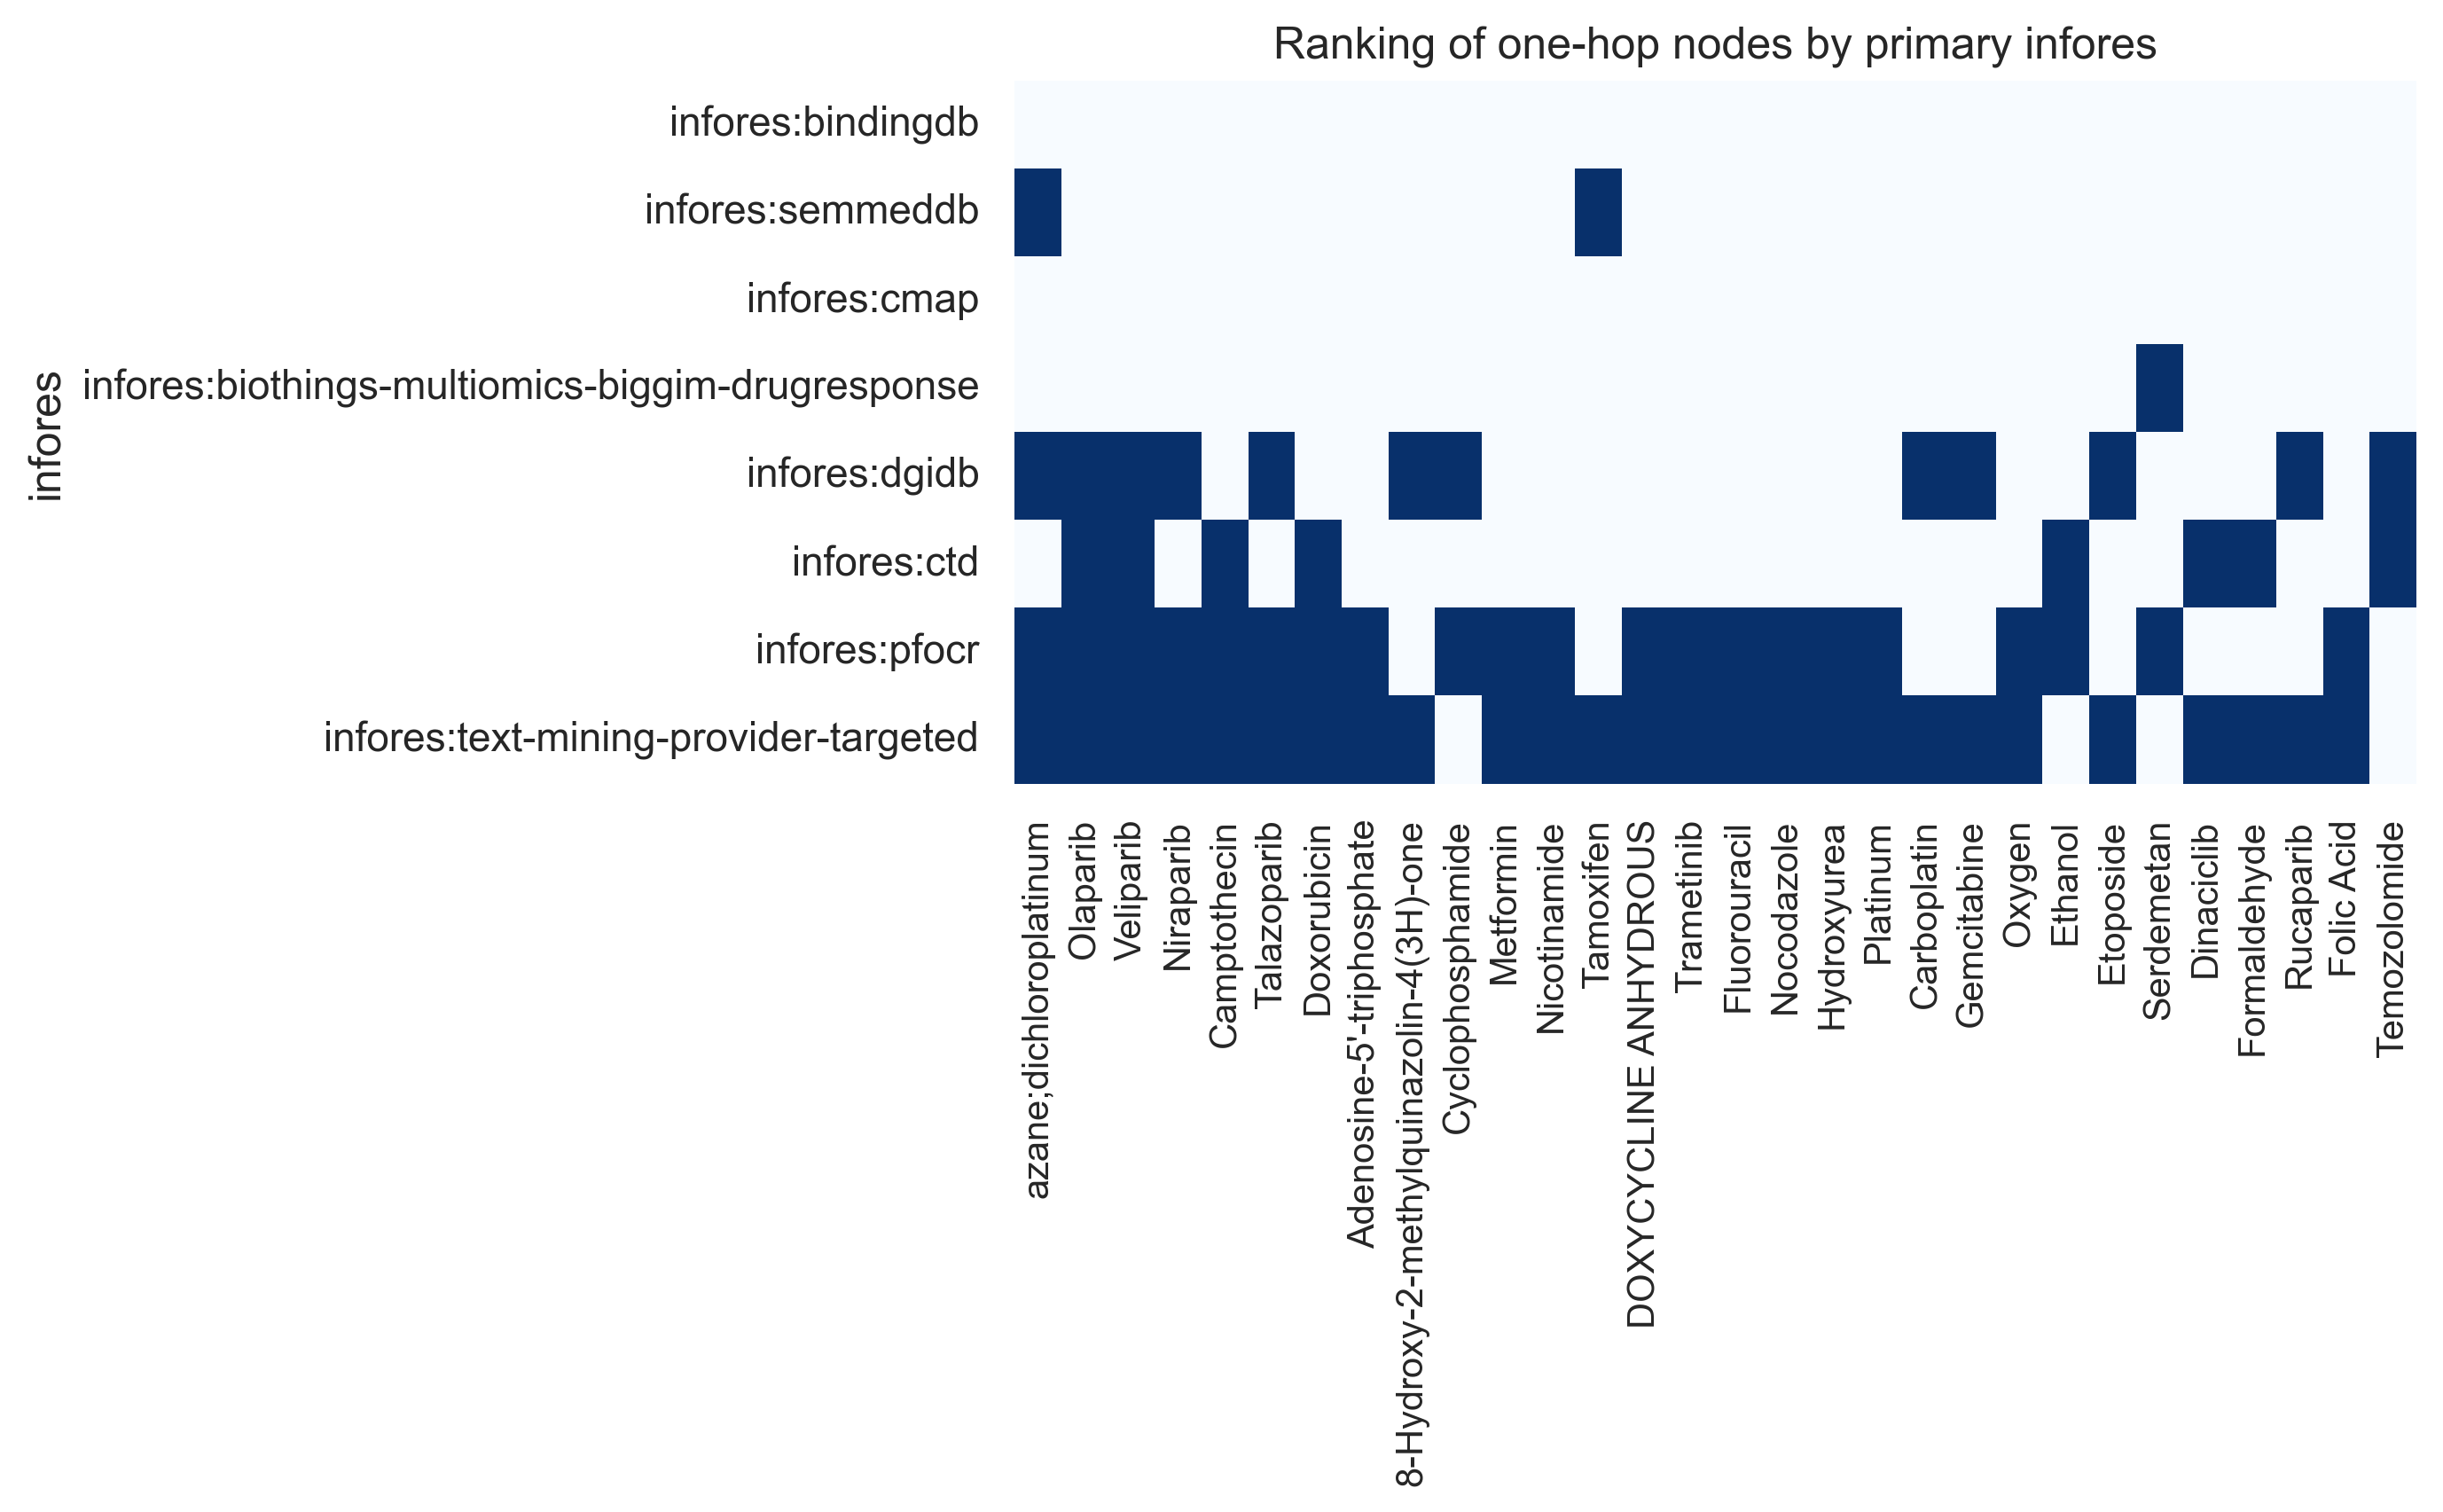

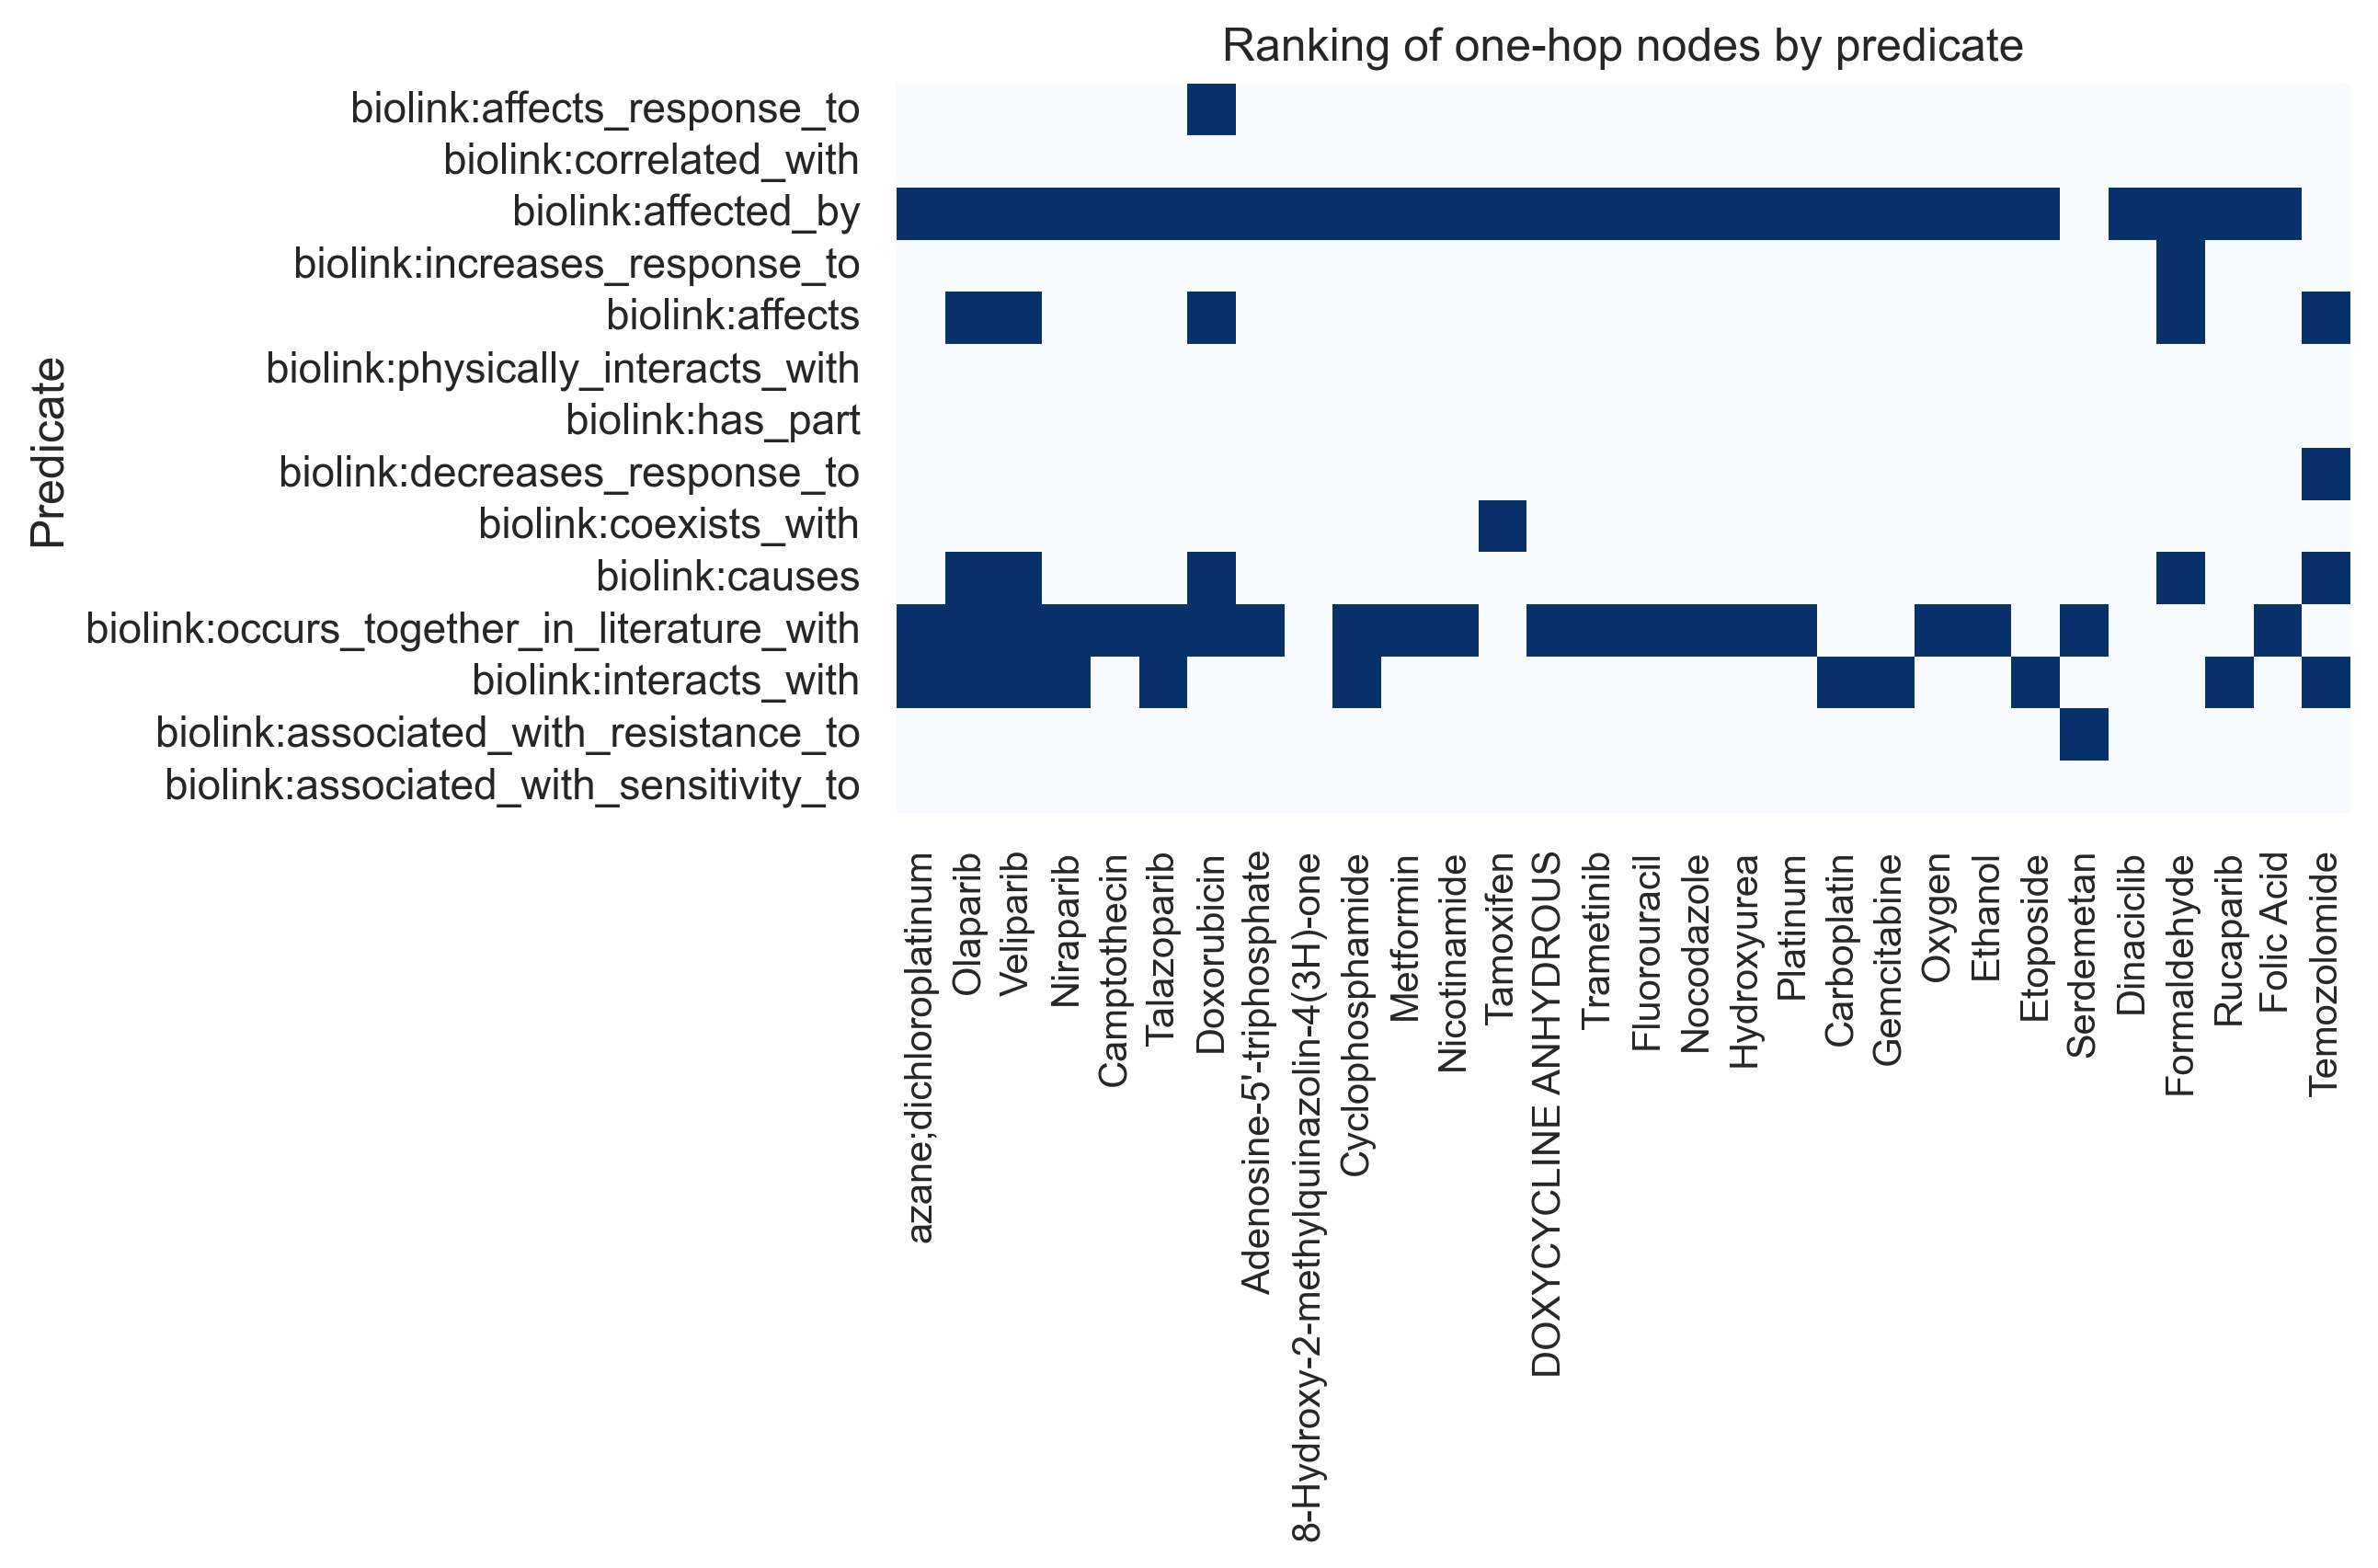

In [15]:
# Step 8: Visualize the results
TCT.visulization_one_hop_ranking(result_ranked_by_primary_infores, 
                                 result_parsed, 
                                 num_of_nodes = 30, 
                                 input_query = input_node1_id,
                                 fontsize = 10,
                                 title_fontsize=12)

In [8]:
# Step 9: Format query json
query_json2 = TCT.format_query_json(input_node3_list,  # a list of identifiers for input node1
                                   input_node2_list,  # it can be empty list if only want to query node1
                                   input_node3_category,  # a list of categories of input node1
                                   input_node2_category,  # a list of categories of input node2
                                   sele_predicates_2) # a list of predicates


In [9]:
# Step 10: Query Translator APIs and parse results
result2 = TCT.parallel_api_query(API_URLs_2,query_json=query_json2, max_workers=len(API_URLs_2))

# Step 11: Parse results
result_parsed2 = TCT.parse_KG(result2)

# Step 12: Ranking the results. This ranking method is based on the number of unique primary infores. It can only be used to rank the results with one defined node.
result_ranked_by_primary_infores2 = TCT.rank_by_primary_infores(result_parsed2, input_node3_id)   # input_node1_id is the curie id of the input node, such as "NCBIGene:672"


'https://automat.ci.renci.org/drugcentral/1.4/query' generated an exception: HTTPSConnectionPool(host='automat.ci.renci.org', port=443): Max retries exceeded with url: /drugcentral/1.4/query (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x1400ff880>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known'))
Warning Code:404:https://api.bte.ncats.io/v1/bde72db681ec0b8f9eeb67bb6b8dd72c/query
Warning Code:400:https://ars-prod.transltr.io/ara-robokop/api/runquery
Warning Code:404:https://automat.ci.transltr.io/ubergraph-nonredundant/1.4/query
Warning Code:404:https://automat.renci.org/biolink/1.4/query
Success!https://automat.ci.transltr.io/hetio/1.4/query
Success!https://automat.ci.transltr.io/ubergraph/1.4/query
Success!https://automat.renci.org/pharos/1.4/query
Success!https://automat.renci.org/gtopdb/1.4/query
Success!https://automat.renci.org/hmdb/1.4/querySuccess!https://automat.renci.org/icees-kg/1.4/query

Success

PUBCHEM.COMPOUND:10339178:no preferred name
UMLS:C0042845:no preferred name
CHEMBL.COMPOUND:CHEMBL502835:no preferred name
MESH:D004921:no preferred name
MESH:D000069585:no preferred name
CHEMBL.COMPOUND:CHEMBL1201583:no preferred name
UNII:3XC8GUZ6CB:no preferred name
MESH:D000080045:no preferred name
DRUGBANK:DB06448:no preferred name
CHEMBL.COMPOUND:CHEMBL1201832:no preferred name
MESH:D000077214:no preferred name
CHEMBL.COMPOUND:CHEMBL1789844:no preferred name
UMLS:C1879521:no preferred name
DRUGBANK:DB12108:no preferred name
DRUGBANK:DB02701:no preferred name
CHEMBL.COMPOUND:CHEMBL2068237:no preferred name
MESH:C416023:no preferred name
MESH:C034483:no preferred name
MESH:C455861:no preferred name
MESH:D008942:no preferred name
CHEMBL.COMPOUND:CHEMBL1386:no preferred name
CHEMBL.COMPOUND:CHEMBL1201568:no preferred name
CHEMBL.COMPOUND:CHEMBL1743082:no preferred name
CHEMBL.COMPOUND:CHEMBL3989514:no preferred name
CHEMBL.COMPOUND:CHEMBL1201587:no preferred name
PUBCHEM.COMPOUND:605

<AxesSubplot:title={'center':'Ranking of one-hop nodes by predicate'}, ylabel='Predicate'>

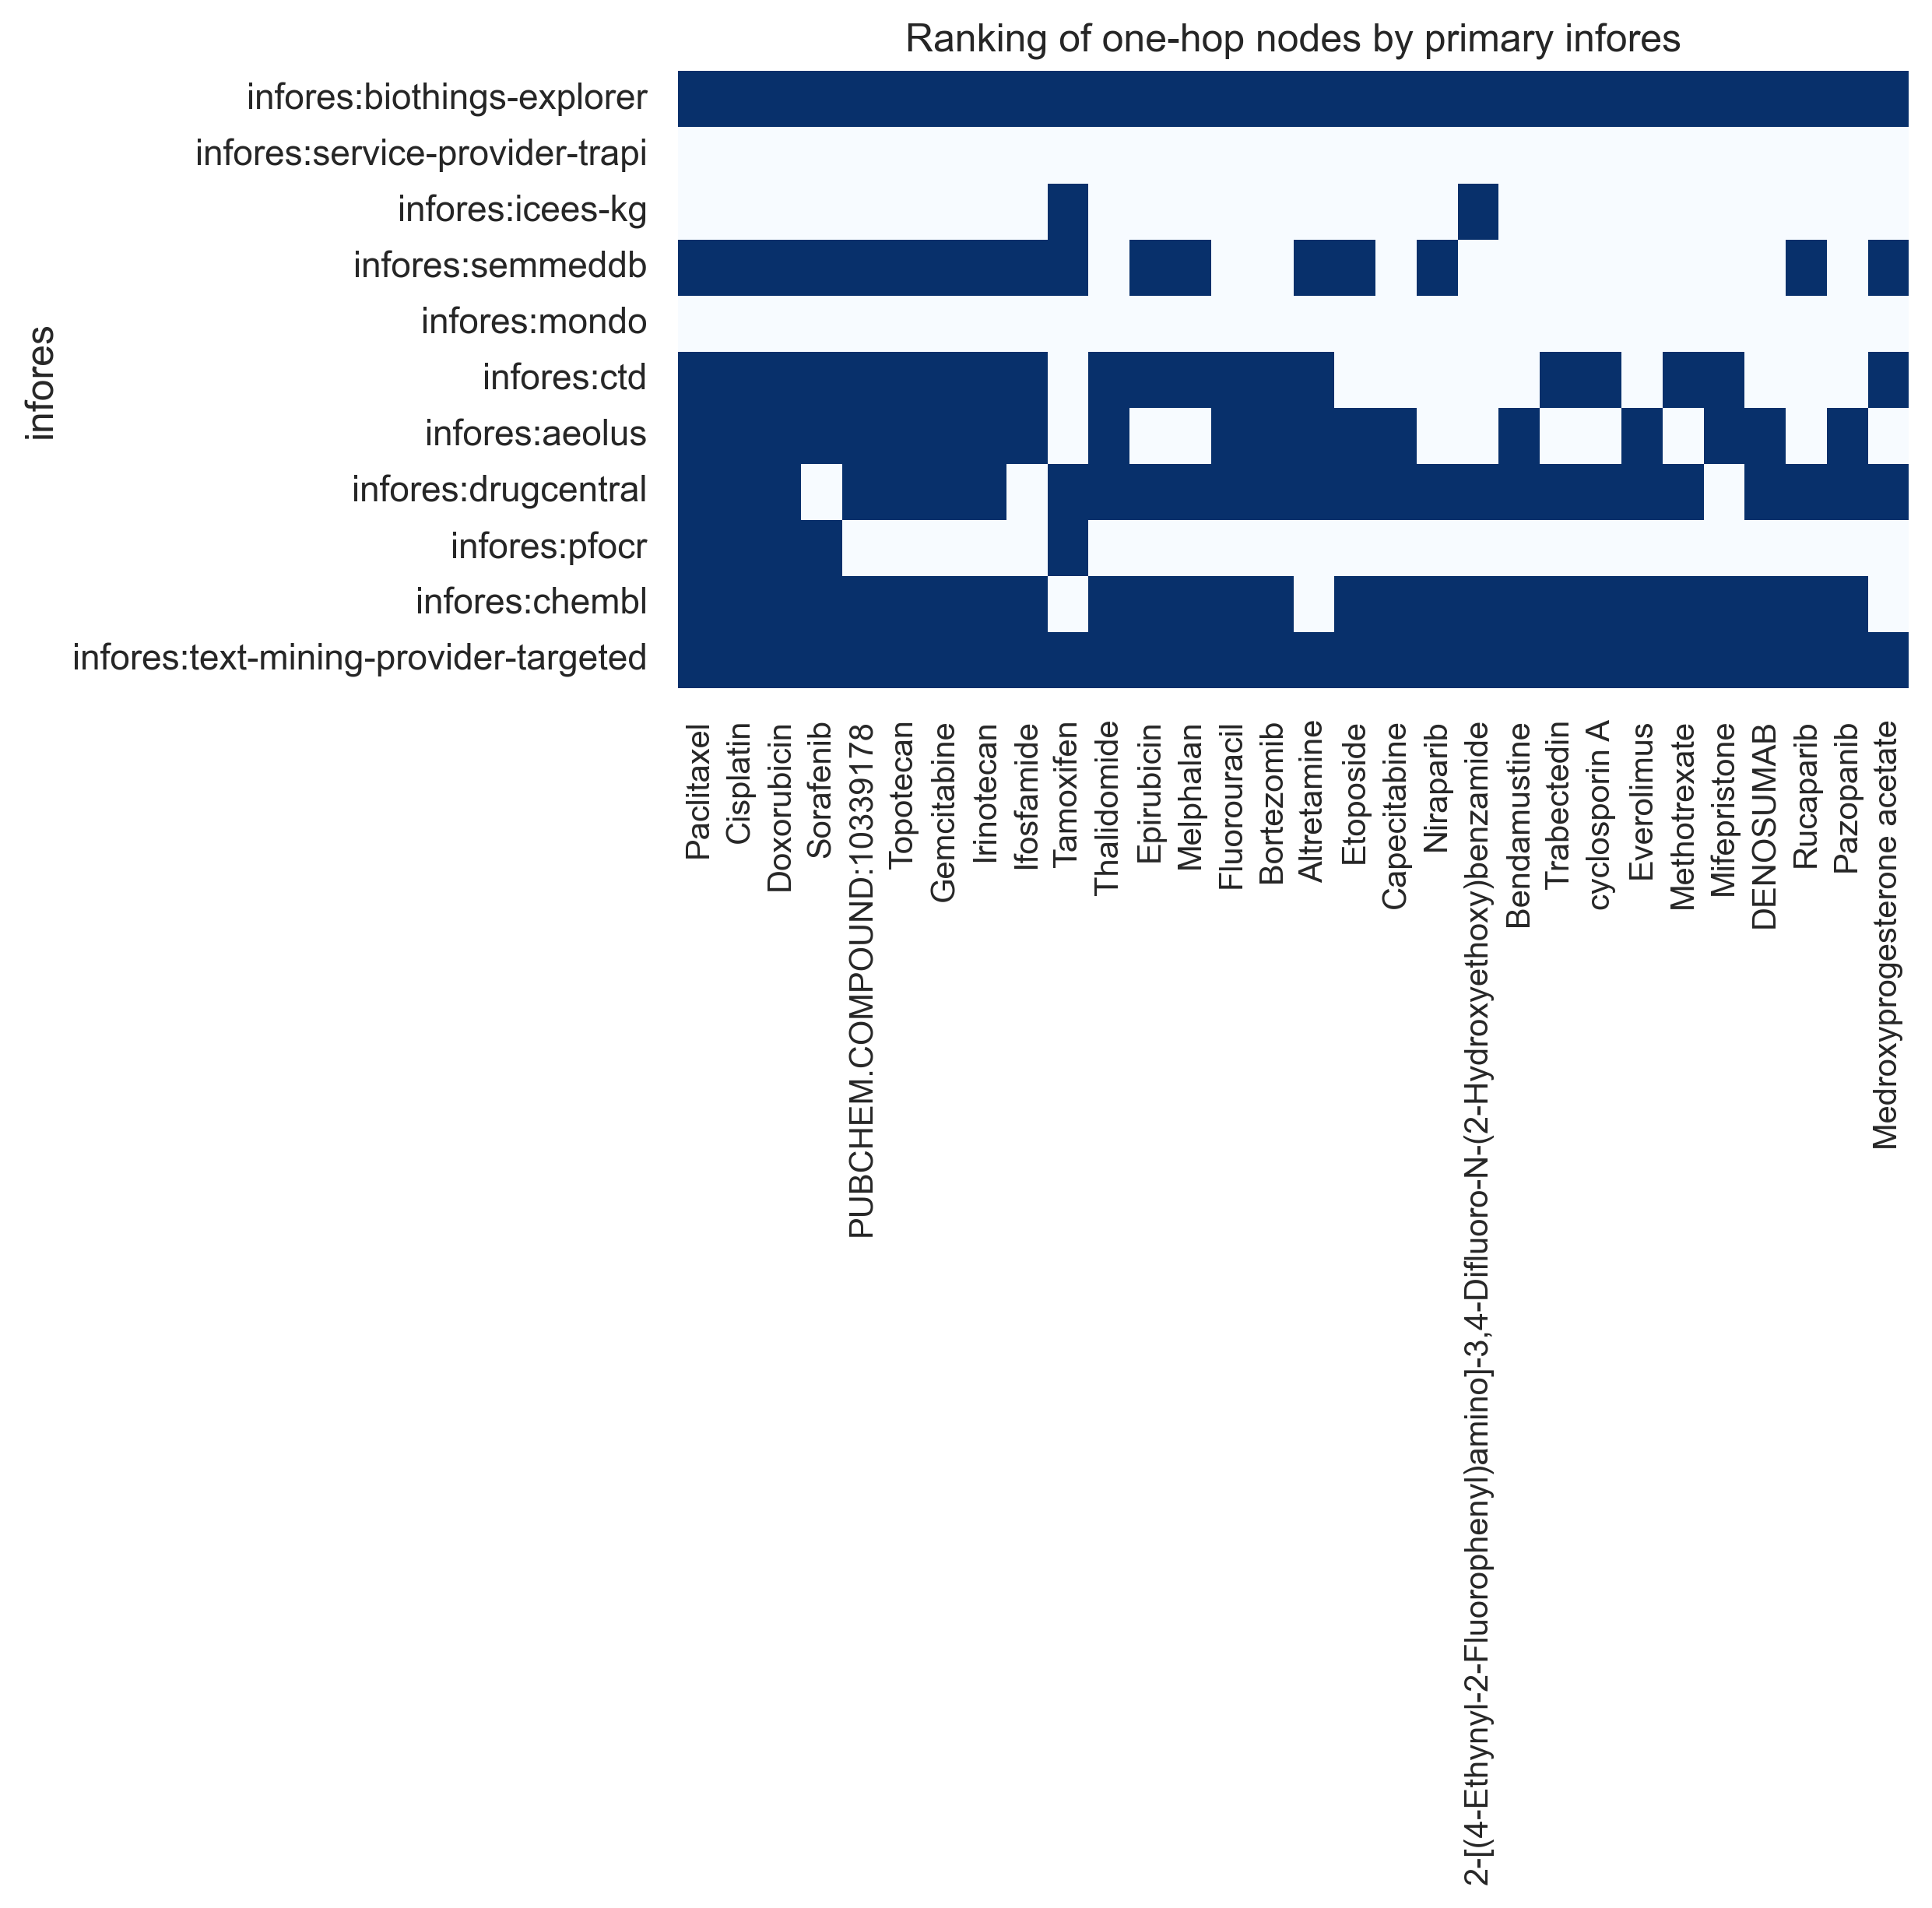

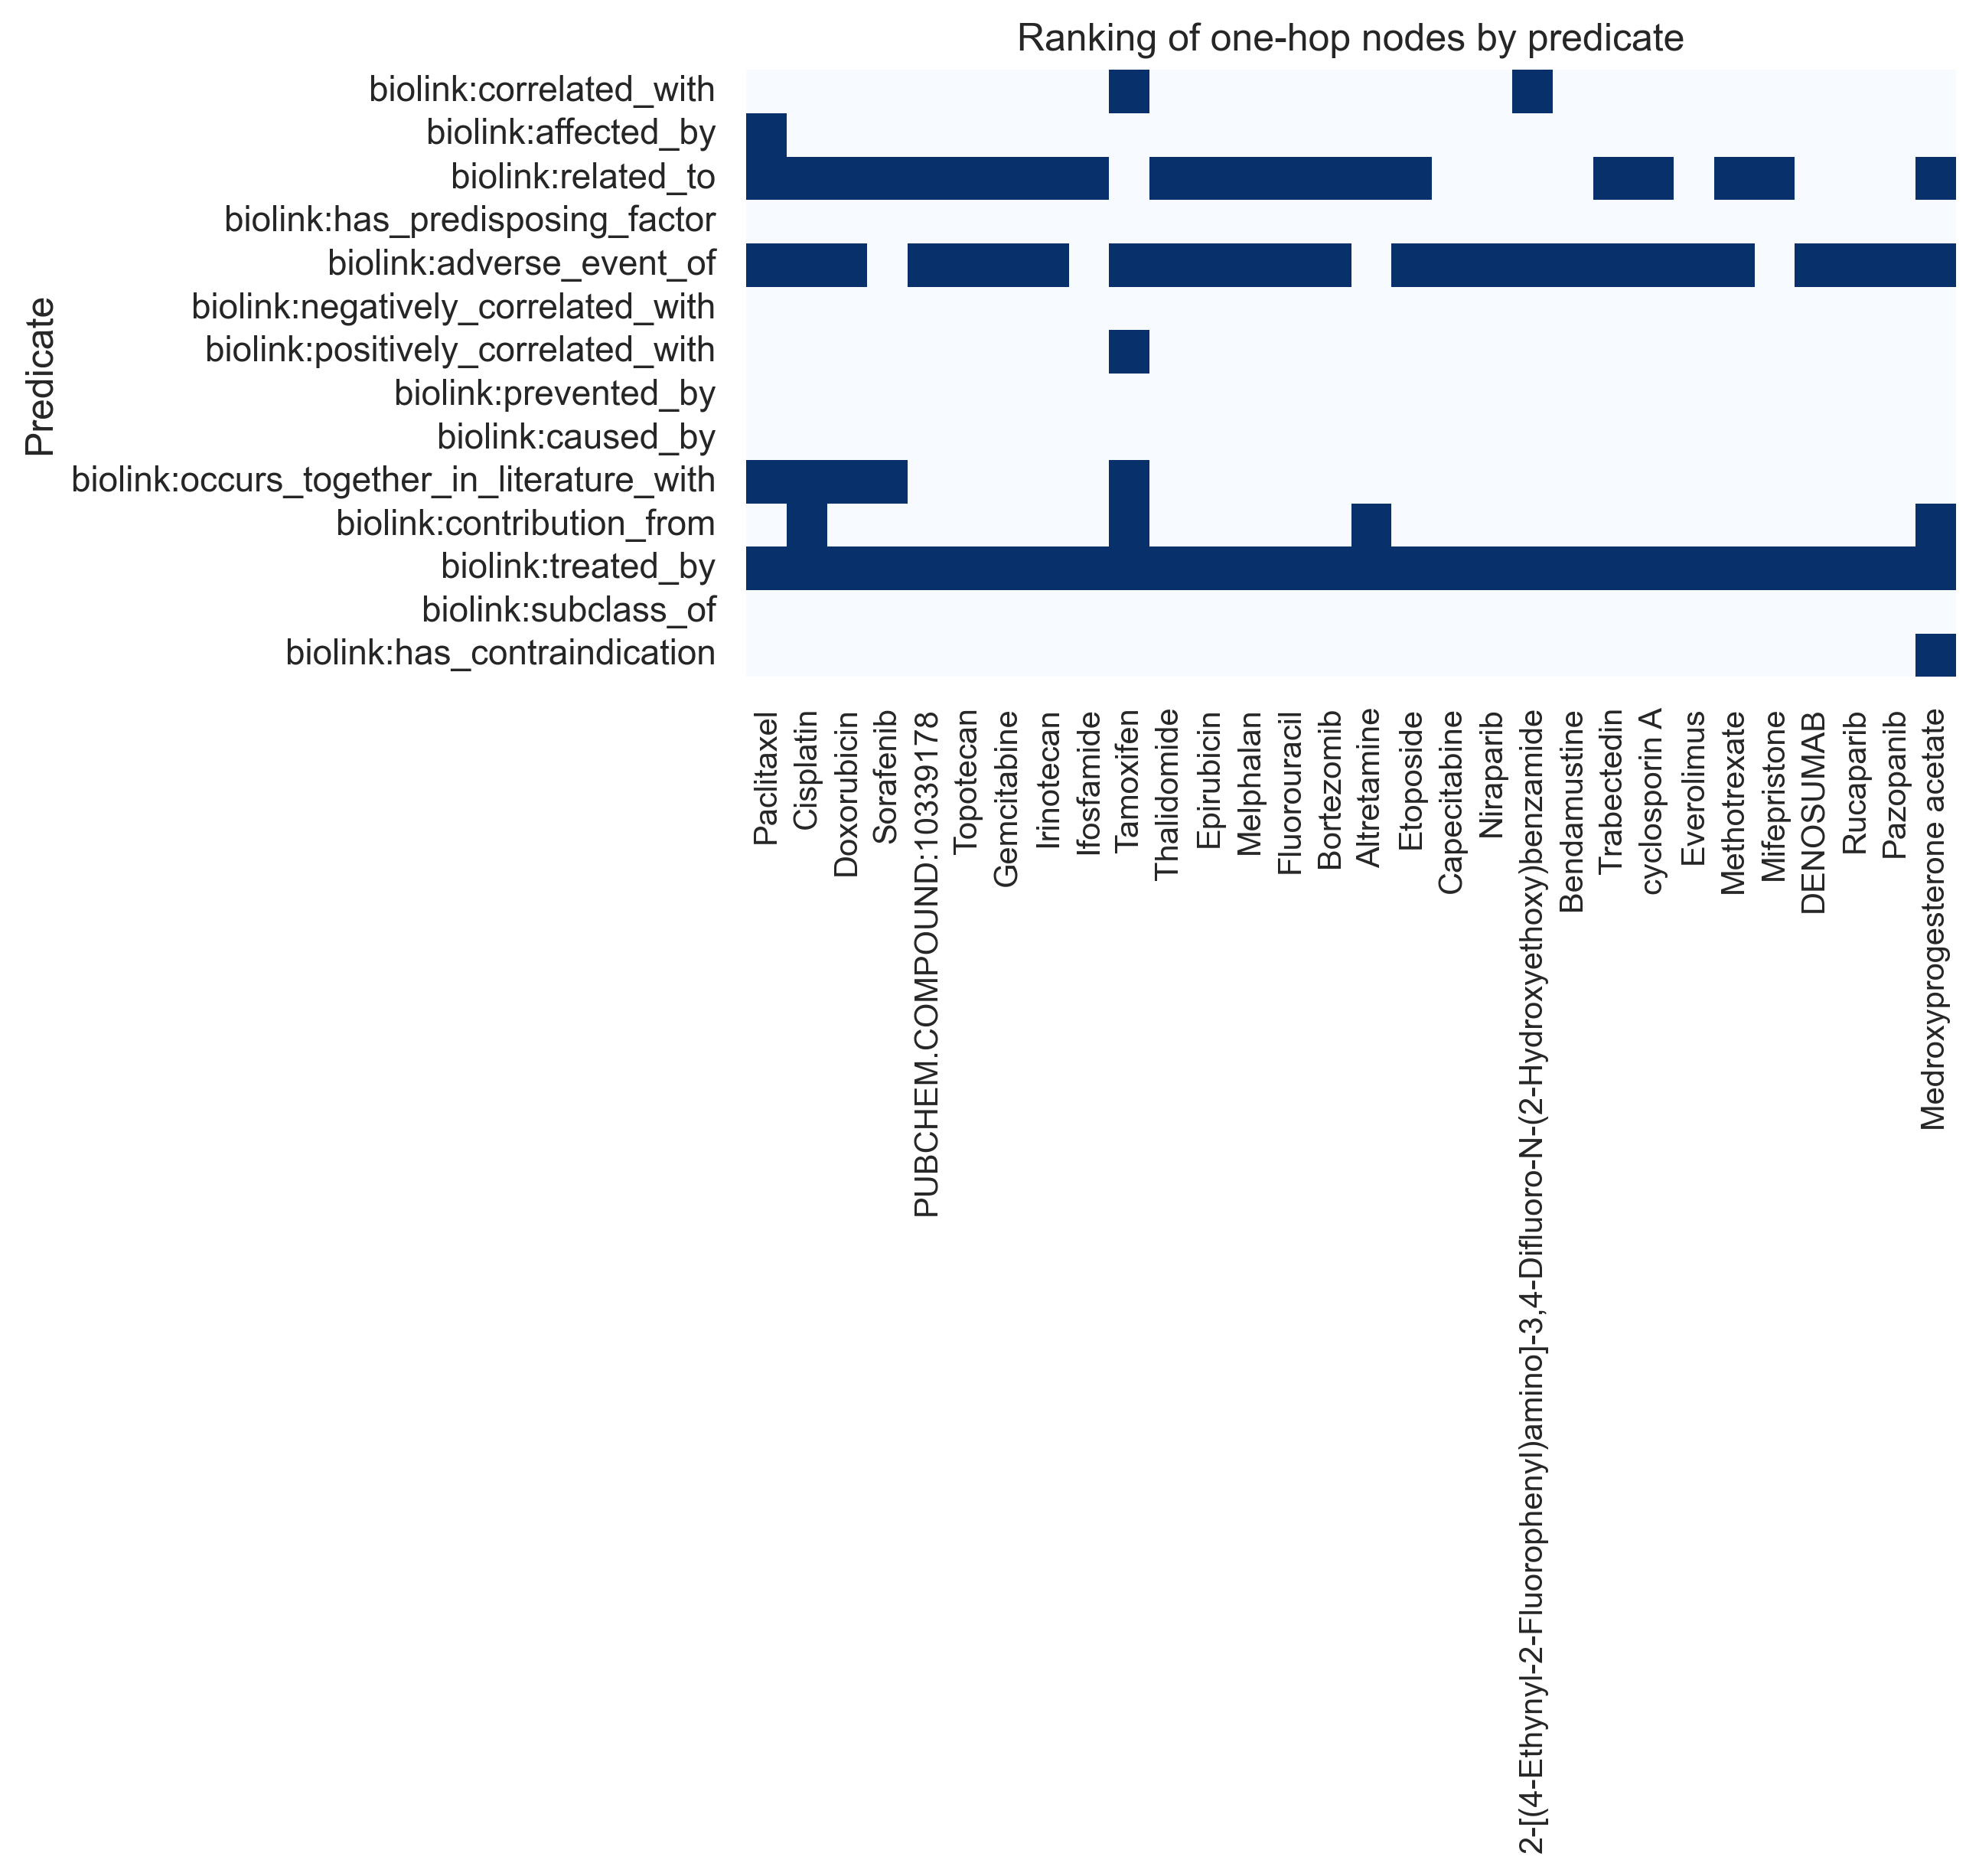

In [16]:
# Step 13: Visualize the results
TCT.visulization_one_hop_ranking(result_ranked_by_primary_infores2, result_parsed2, num_of_nodes = 30, 
                                 input_query = input_node3_id,
                                 fontsize = 10,
                                 title_fontsize=12)

In [17]:
possible_paths = len(set(result_ranked_by_primary_infores['output_node']).intersection(set(result_ranked_by_primary_infores2['output_node'])))
print("Number of possible paths: ", possible_paths)


Number of possible paths:  219


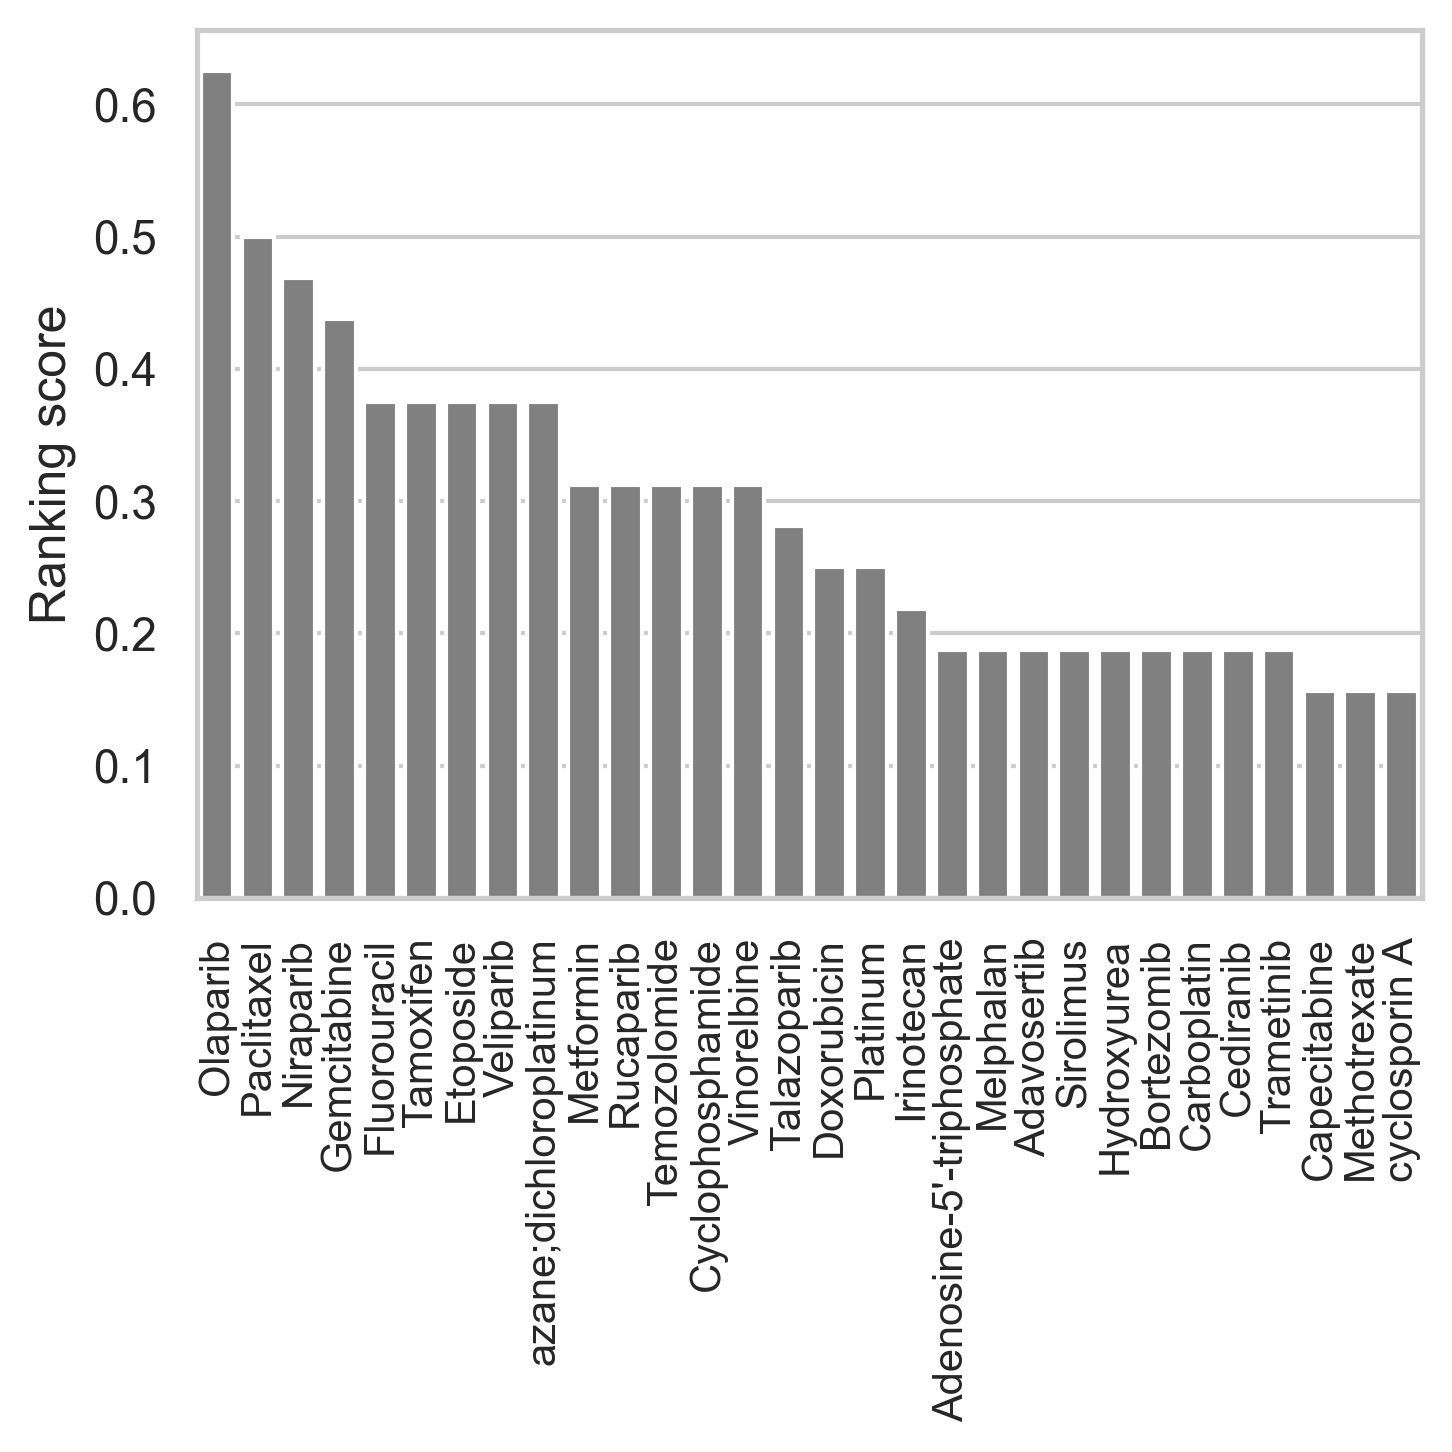

,score
Olaparib,0.62500
Paclitaxel,0.50000
Niraparib,0.46875
Gemcitabine,0.43750
Fluorouracil,0.37500
...,...
Actinium,0.03125
Sulfur,0.03125
Rabusertib,0.03125
Afimoxifene,0.03125


In [18]:
TCT.merge_ranking_by_number_of_infores(result_ranked_by_primary_infores, result_ranked_by_primary_infores2, 
                                       top_n = 30,
                                       fontsize=10,
                                       title_fontsize=12,)

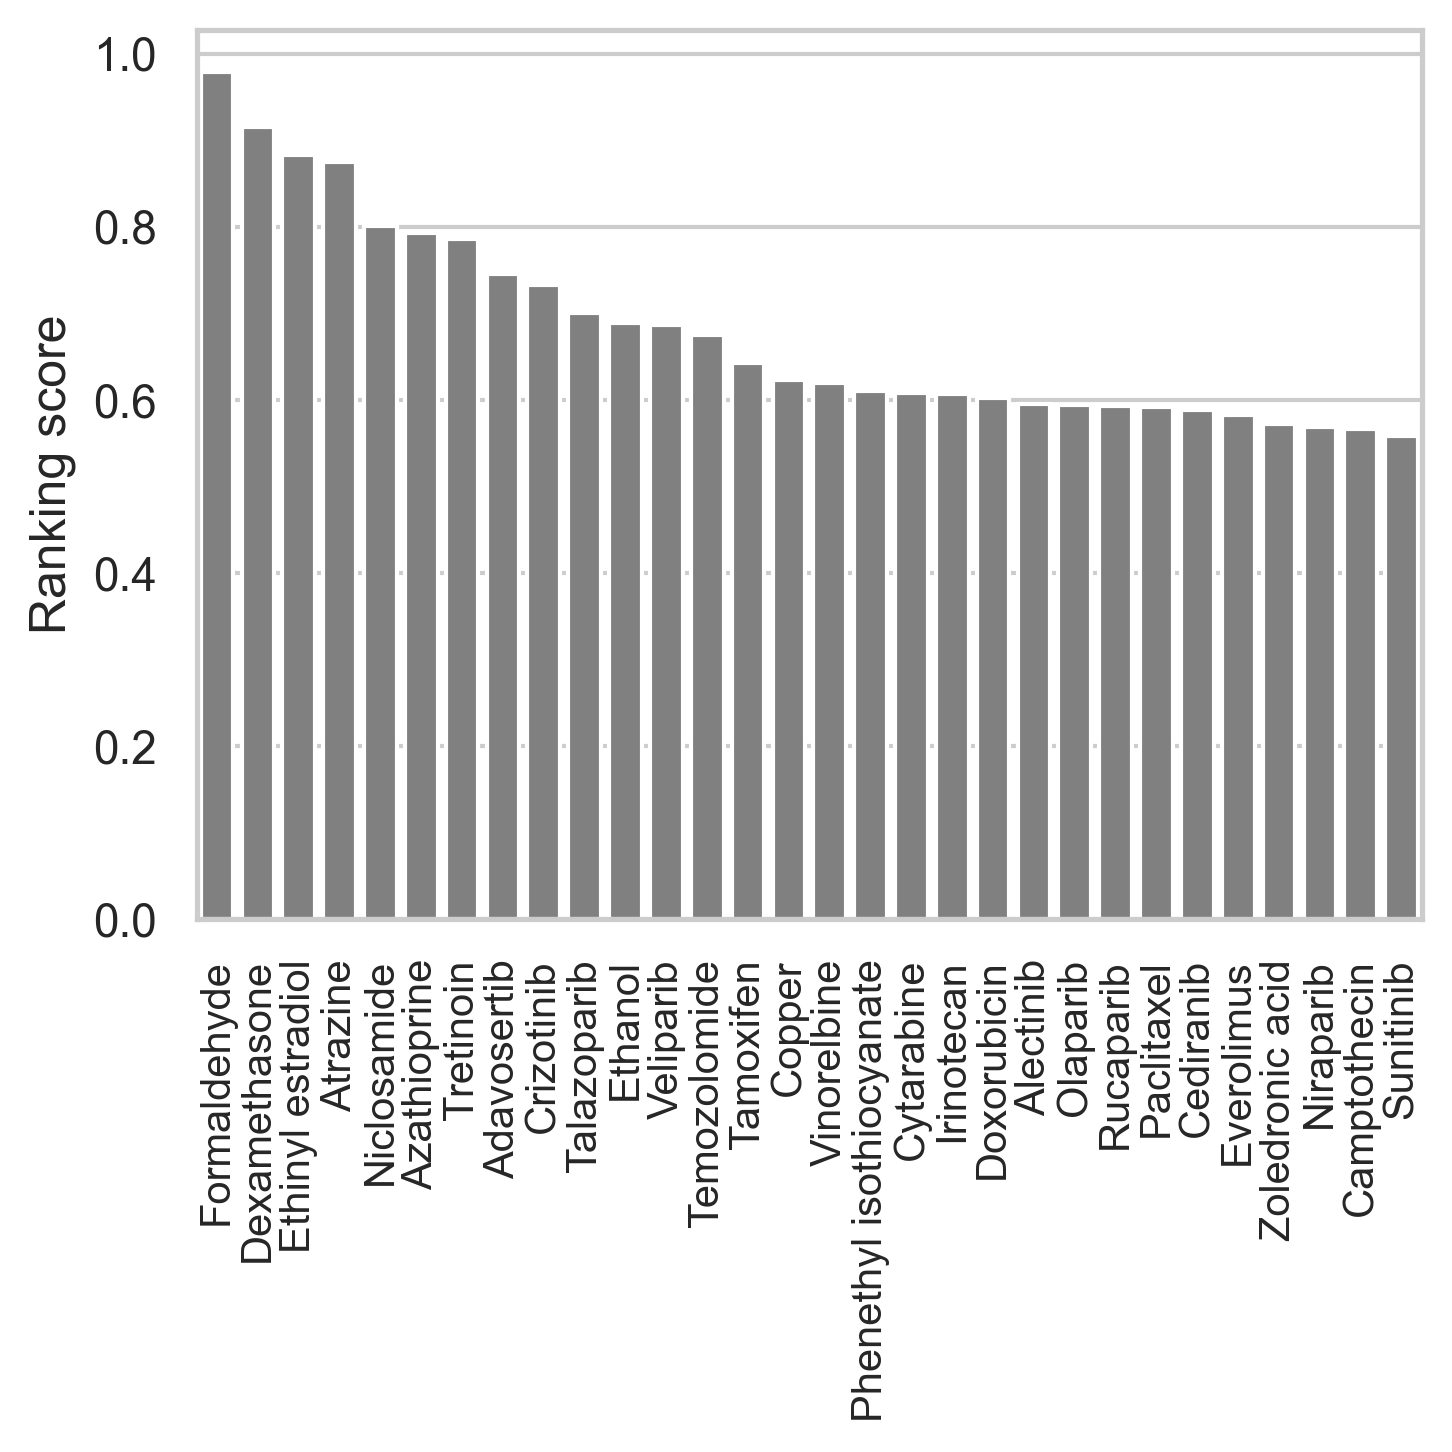

,output_node,score
Formaldehyde,PUBCHEM.COMPOUND:712,0.978526
Dexamethasone,PUBCHEM.COMPOUND:5743,0.914900
Ethinyl estradiol,PUBCHEM.COMPOUND:5991,0.883430
Atrazine,PUBCHEM.COMPOUND:2256,0.874776
Niclosamide,PUBCHEM.COMPOUND:4477,0.800767
...,...,...
Curcumin,PUBCHEM.COMPOUND:969516,0.006288
Lauric Acid,PUBCHEM.COMPOUND:3893,0.005512
Methenamine,PUBCHEM.COMPOUND:4101,0.002840
Rotenone,PUBCHEM.COMPOUND:6758,0.002668


In [19]:
TCT.merge_by_ranking_index(result_ranked_by_primary_infores,
                           result_ranked_by_primary_infores2, 
                           top_n=30, fontsize=10, 
                           title_fontsize=12)